# Logistic Regression with the Breast Cancer Wisconsin Dataset

## Import required libraries

In [2]:
import numpy as np
import logging
import sys
import matplotlib.pyplot as plt
from collections import namedtuple
from tqdm import tqdm
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, KFold

logging.basicConfig(stream=sys.stderr, level=logging.INFO)
plt.style.use("seaborn-darkgrid")
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Load the Breast Cancer Wisconsin Dataset

In [2]:
X, y = load_breast_cancer(return_X_y=True)

## Information on the Breast Cancer Dataset

Attribute information:

-   radius (mean of distances from center to points on the perimeter)
-   texture (standard deviation of gray-scale values)
-   perimeter area
-   smoothness (local variation in radius lengths)
-   compactness (perimeter^2 / area - 1.0)
-   concavity (severity of concave portions of the contour)
-   concave points (number of concave portions of the contour)
-   symmetry fractal dimension (“coastline approximation” - 1)

The mean, standard error, and “worst” or largest (mean of the three largest values) of these
features were computed for each image, resulting in 30 features. For instance, field 3 is Mean
Radius, field 13 is Radius SE, field 23 is Worst Radius.

In [3]:
print(f"Dimension of X_feat is {X.shape} and y_target is {y.shape}")

Dimension of X_feat is (569, 30) and y_target is (569,)


## Logistic Regression Class and Utility Classes

In [4]:
model_parameter = namedtuple("model_parameter", ("lambda_ridge, alpha, epochs"))

In [5]:
class Preprocessing:
    def __init__(self):
        self.mean = None
        self.std = None

    @staticmethod
    def standardize(X, mean=None, std=None, inplace=False):
        if mean is None:
            mean = np.mean(X, axis=0)
        if std is None:
            std = np.std(X, axis=0)

        std = np.where(std == 0, 1, std)
        if inplace:
            X -= mean
            X /= std
        else:
            X = (X - mean) / std
        return X

    @staticmethod
    def insert_bias_term(X):
        bias_arr = np.ones(X.shape[0])
        return np.c_[bias_arr, X]

    def standardize_save_state(self, X, mean=None, std=None, inplace=False):
        if mean is None:
            mean = np.mean(X, axis=0)
        if std is None:
            std = np.std(X, axis=0)

        std = np.where(std == 0, 1, std)
        self.mean = mean
        self.std = std
        if inplace:
            X -= mean
            X /= std
        else:
            X = (X - mean) / std
        return X

    def fit(self, X, inplace=False):
        if self.mean is None or self.std is None:
            raise ValueError("Mean or std is not for the preprocessing object")
        if inplace:
            X -= self.mean
            X /= self.std
        else:
            X = (X - self.mean) / self.std
        return X

In [6]:
class LogisticRegr:
    slots = ["theta"]

    def __init__(self):
        self.theta = None

    def __repr__(self):
        return " ".join([str(val) for val in np.ndarray.flatten(self.theta)])

    def fit(
        self,
        X,
        y,
        logging_enabled=True,
        model_params=model_parameter(lambda_ridge=0, alpha=0.5, epochs=5000),
    ):
        """
        WARNING: X must be normalized and have the bias term before training
        Batch Gradient Descent for logistic regression
        """
        if X.shape[0] != y.shape[0]:
            raise ValueError(
                f"X shape {X.shape[0]} != y shape {y.shape[0]}. Dimensions not matching"
            )

        loss_arr = []
        m = X.shape[0]
        self.theta = np.zeros(X.shape[1])
        lambda_ridge, alpha, epochs = model_params

        for epoch in range(epochs):
            gradient_wout_regu = (1 / m) * np.dot(
                np.matrix.transpose(X), LogisticRegr.sigmoid(np.dot(X, self.theta)) - y
            )
            # 0th parameter/bias is not regularized
            self.theta[0] = self.theta[0] - alpha * gradient_wout_regu[0]
            gradient_with_regu = gradient_wout_regu + ((lambda_ridge / m) * self.theta)
            # All other parameters regularized
            self.theta[1:] = self.theta[1:] - alpha * gradient_with_regu[1:]

            if epoch % 100 == 0:
                current_log_loss = self.loss(X, y, lambda_ridge)
                if logging_enabled:
                    print(f"Loss at epoch {epoch} is {current_log_loss}")
                loss_arr.append(current_log_loss)

        if logging_enabled:
            self.plot_loss_curve(loss_arr, epochs)

    def plot_loss_curve(self, loss_arr, epochs, log_scale: bool = False):
        if log_scale:
            plt.semilogx(range(epochs), loss_arr)
        else:
            plt.plot(loss_arr)
        plt.ylabel("log loss")
        plt.xlabel("Epoch (x100)")
        plt.title("Loss Overtime")
        plt.grid(True)
        plt.show()

    @staticmethod
    def log_loss(X, y, theta, lambda_ridge: float = 0.0):
        if X.shape[0] != y.shape[0]:
            raise ValueError(
                f"X shape {X.shape[0]} != y shape {y.shape[0]}. Dimensions not matching"
            )
        elif X.shape[1] != theta.shape[0]:
            raise ValueError(
                f"X shape {X.shape[1]} != theta shape {theta.shape[0]}. Dimensions not matching"
            )

        m = X.shape[0]
        h = LogisticRegr.sigmoid(np.dot(X, theta))
        # loss J(theta) = -(1/m)*(yt*logh + (1-y)t*log(1-h)) + lambda/2m theta_t * theta
        return (-1 / m) * (
            np.dot(np.matrix.transpose(y), np.log(h))
            + np.dot(np.matrix.transpose(1 - y), np.log(1 - h))
        ) + (
            (lambda_ridge / (2 * m)) * np.dot(np.matrix.transpose(theta[1:]), theta[1:])
        )

    @staticmethod
    def sigmoid(X):
        return 1 / (1 + np.exp(-X))

    @staticmethod
    def predict(X, theta, threshold: float = 0.5):
        prediction = np.dot(X, theta)
        prediction[prediction >= threshold] = 1
        prediction[prediction < threshold] = 0
        return prediction

    def loss(self, X, y, lambda_ridge: float = 0.0):
        return LogisticRegr.log_loss(X, y, self.theta, lambda_ridge)

    def accuracy(self, X, y, threshold: float = 0.5):
        """
        accuracy = (TP+TN) / (TP+FP+TN+FN)
        """
        y_pred = LogisticRegr.predict(X, self.theta, threshold)
        return (
            len([1 for y_true, y_hat in zip(y, y_pred) if y_true == y_hat]) / X.shape[0]
        )

    def precision(self, X, y, threshold: float = 0.5):
        """
        Ratio of correctly predicted positive observations to total positive observations
        precision = TP / (TP+FP)
        """
        y_pred = LogisticRegr.predict(X, self.theta, threshold)
        true_positives = len(
            [1 for y_true, y_hat in zip(y, y_pred) if y_true == y_hat == 1]
        )
        total_positives_pred = sum(y_pred)
        return true_positives / total_positives_pred

    def recall(self, X, y, threshold: float = 0.5):
        """
        Also known as Sensitivity
        Ratio of correctly predicted positive observations to all observations that are actually positive
        recall = TP / (TP+FN)
        """
        y_pred = LogisticRegr.predict(X, self.theta, threshold)
        true_positives = len(
            [1 for y_true, y_hat in zip(y, y_pred) if y_true == y_hat == 1]
        )
        true_pos_and_false_neg = len(
            [
                1
                for y_true, y_hat in zip(y, y_pred)
                if y_true == y_hat == 1 or (y_true == 1 and y_hat == 0)
            ]
        )
        return true_positives / true_pos_and_false_neg

    def f1_score(self, X, y, threshold: float = 0.5):
        """
        Weighted average of precision and recall
        Preferred to accuracy as accuracy is misleading for unbalanced datasets
        f1_score = 2*(Recall*Precision) / (Recall+Precision)
        """
        recall = self.recall(X, y, threshold)
        precision = self.precision(X, y, threshold)
        return (2 * recall * precision) / (recall + precision)

    def plot_confusion_matrix(self, X, y, threshold: float = 0.5, custom: bool = True):
        y_pred = LogisticRegr.predict(X, self.theta, threshold)

        tp = len([1 for y_true, y_hat in zip(y, y_pred) if y_true == y_hat == 1])
        tn = len([1 for y_true, y_hat in zip(y, y_pred) if y_true == y_hat == 0])
        fp = len([1 for y_true, y_hat in zip(y, y_pred) if y_true == 0 and y_hat == 1])
        fn = len([1 for y_true, y_hat in zip(y, y_pred) if y_true == 1 and y_hat == 0])
        if custom:  # use custom confusion matrix generator
            print("\t\t\t      Actual values")
            print("\t\t\tPositive(1)   Negative(0)")
            print(f"Predicted| Positive(1)     TP {tp}\t  FP {fp}")
            print(f"  Values | Negative(0)     FN {fn}\t\t  TN {tn}")
        else:  # use sklearn.metrics.confusion_matrix
            pass

In [7]:
class KFoldCrossValidator:
    __slots__ = ["train_loss", "test_loss", "train_accuracy", "test_accuracy", "theta"]

    def __init__(self):
        self.train_loss = []
        self.test_loss = []
        self.train_accuracy = []
        self.test_accuracy = []
        self.theta = None

    def cross_validate(
        self,
        model,
        X,
        y,
        k=10,
        logging_enabled=True,
        model_params=model_parameter(lambda_ridge=0, alpha=0.5, epochs=5000),
        custom_kfold=False,
        seed=np.random.randint(10000),
    ):
        """
        Cross validation function, the theta parameter chosen is from the split with the least test error
        """

        m = X.shape[0]
        lambda_ridge, alpha, epochs = model_params
        min_test_error = float("inf")  # tracks the minimum error with k-folds
        best_fit_theta = None  # saves the best theta value with the min_test_error
        preprocessor_object = Preprocessing()

        if custom_kfold:
            logging.info(
                f"Running Custom KFoldCrossValidator with {k} folds and lambda={lambda_ridge}"
            )
            np.random.seed(seed)  # seed random shuffler
            if m < k:
                raise ValueError(
                    f"No of k splits {k} cannot be greater than no. of samples {m}"
                )

            # Randomly shuffle X and y inplace while matching corresponding feat and target
            for i in range(m):
                swap_idx = np.random.randint(i, m)
                # ensures the corresponding feat-target values match
                X[[i, swap_idx]] = X[[swap_idx, i]]
                y[[i, swap_idx]] = y[[swap_idx, i]]

            # test start and end idx
            fold_step = m // k
            start = 0
            end = fold_step

            for i in range(k):
                end = min(end, m)  # prevent array idx out of bounds
                X_train, X_test = (
                    np.concatenate([X[0:start], X[end:m]], axis=0),
                    X[start:end],
                )
                y_train, y_test = (
                    np.concatenate([y[0:start], y[end:m]], axis=0),
                    y[start:end],
                )
                start += fold_step
                end += fold_step

                X_train = preprocessor_object.standardize_save_state(X_train)
                X_test = preprocessor_object.fit(
                    X_test
                )  # standardizing X_test with X_train params

                X_train = Preprocessing.insert_bias_term(X_train)
                X_test = Preprocessing.insert_bias_term(X_test)

                model.fit(X_train, y_train, logging_enabled, model_params)
                cur_train_loss = model.loss(X_train, y_train, lambda_ridge)
                cur_test_loss = model.loss(X_test, y_test, lambda_ridge)
                self.train_loss.append(cur_train_loss)
                self.test_loss.append(cur_test_loss)

                if cur_test_loss < min_test_error:
                    min_test_error = cur_test_loss
                    best_fit_theta = model.theta
        else:
            logging.info(
                f"Running Sklearn KFoldCrossValidator with {k} folds and lambda {lambda_ridge}"
            )
            kf = KFold(n_splits=k, random_state=seed, shuffle=True)
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                X_train = preprocessor_object.standardize_save_state(X_train)
                X_test = preprocessor_object.fit(
                    X_test
                )  # standardizing X_test with X_train params

                X_train = Preprocessing.insert_bias_term(X_train)
                X_test = Preprocessing.insert_bias_term(X_test)

                model.fit(X_train, y_train, logging_enabled, model_params)
                cur_train_loss = model.loss(X_train, y_train, lambda_ridge)
                cur_test_loss = model.loss(X_test, y_test, lambda_ridge)
                self.train_loss.append(cur_train_loss)
                self.test_loss.append(cur_test_loss)

                if cur_test_loss < min_test_error:
                    min_test_error = cur_test_loss
                    best_fit_theta = model.theta
        self.theta = best_fit_theta

## Training our Logistic regression model and plotting the objective loss function at every 100 iteration of gradient descent

**NOTE** We use the log loss function so plot a gradient descent plot

Loss at epoch 0 is 0.24583876431866866
Loss at epoch 100 is 0.07843872123186416
Loss at epoch 200 is 0.06872372926403282
Loss at epoch 300 is 0.063834659516147
Loss at epoch 400 is 0.06068011883471133
Loss at epoch 500 is 0.058411311866183174
Loss at epoch 600 is 0.05667270894909987
Loss at epoch 700 is 0.05527319396712619
Loss at epoch 800 is 0.054099023669670766
Loss at epoch 900 is 0.05308189470043131
Loss at epoch 1000 is 0.05217977595024646
Loss at epoch 1100 is 0.05136553120349583
Loss at epoch 1200 is 0.05062077451720506
Loss at epoch 1300 is 0.04993253125857482
Loss at epoch 1400 is 0.049291330052199406
Loss at epoch 1500 is 0.048690054855306183
Loss at epoch 1600 is 0.04812322409022393
Loss at epoch 1700 is 0.0475865216243665
Loss at epoch 1800 is 0.04707648229594629
Loss at epoch 1900 is 0.04659027550413878
Loss at epoch 2000 is 0.04612555285153405
Loss at epoch 2100 is 0.04568033869953008
Loss at epoch 2200 is 0.045252950126519045
Loss at epoch 2300 is 0.044841937436917445
L

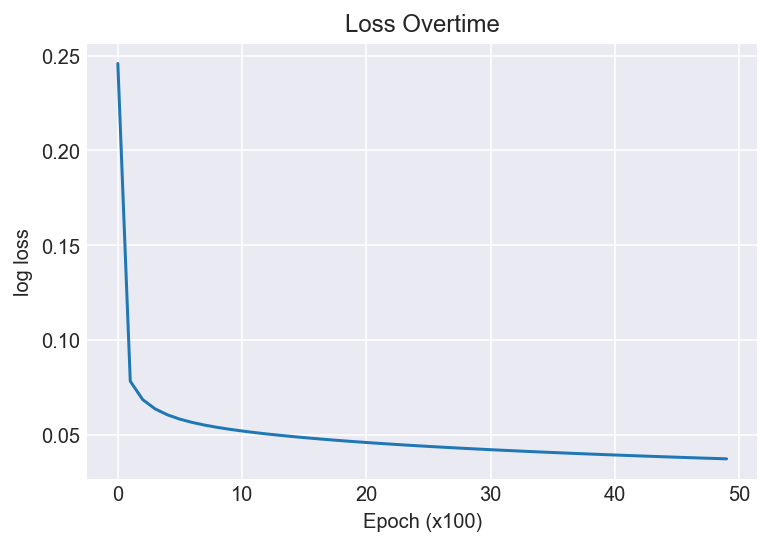

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.40, random_state=42
)

preprocessing_object = Preprocessing()
X_train_std = preprocessing_object.standardize_save_state(X_train)
X_train_std = preprocessing_object.insert_bias_term(X_train_std)

bcw_model = LogisticRegr()
model_params = model_parameter(lambda_ridge=0, alpha=0.5, epochs=5000)

bcw_model.fit(X_train_std, y_train, model_params)

## Looking at the performance of out model with accuracy, precision, recall and the f1 score

In [9]:
print(f"The coefficient vector w or theta trained from our model is {bcw_model.theta}")

The coefficient vector w or theta trained from our model is [-0.68966442  0.21841225  0.40117853  0.28335985 -0.06065617  0.0379248
  3.14934633 -1.88541698 -3.52066927  1.23684842 -0.92544834 -3.46479585
  0.6850434  -1.07373119 -2.35719124 -0.31702896  0.05820801  1.09554224
 -1.70401767  1.24173203  1.58056678 -1.39346711 -3.22423253 -0.29002135
 -1.40487317 -0.21187648  1.29367031 -2.63272468 -1.46349068 -3.41398423
  0.04106486]


In [10]:
X_test = preprocessing_object.fit(
    X_test
)  # Standardize X_test with the same mean and std parameters from X_train
X_test = Preprocessing.insert_bias_term(X_test)
print(
    f"The accuracy of the logistic regr model is {bcw_model.accuracy(X_test, y_test)}"
)
print(
    f"The precision of the logistic regr model is  {bcw_model.precision(X_test, y_test)}"
)
print(f"The recall of the logistic regr model is  {bcw_model.recall(X_test, y_test)}")
print(
    f"The f1 score of the logistic regr model is  {bcw_model.f1_score(X_test, y_test)}"
)
print("The confusion matrix from the results of the logistic regr model:")
bcw_model.plot_confusion_matrix(X_test, y_test)

The accuracy of the logistic regr model is 0.9736842105263158
The precision of the logistic regr model is  0.9930555555555556
The recall of the logistic regr model is  0.9662162162162162
The f1 score of the logistic regr model is  0.9794520547945206
The confusion matrix from the results of the logistic regr model:
			      Actual values
			Positive(1)   Negative(0)
Predicted| Positive(1)     TP 143	  FP 1
  Values | Negative(0)     FN 5		  TN 79


## Running our logistic regression model with different hyperparameters with K Fold Cross Validation

### WARNING EXPENSIVE GRID SEARCH COMPUTATION AHEAD

In [12]:
logger = logging.getLogger()
logger.disabled = True

min_test_error = float("inf")  # tracks the minimum error with k-folds
best_lambda = None  # saves the best theta value with the min_test_error
best_alpha = None  # saves best alpha value
best_epochs = None  # saves best epochs

possible_lambda_ridge = [0, 5, 10, 15]
possible_alpha = [0.4, 0.5, 0.6, 0.7, 0.8]
possible_epochs = [4000, 5000, 7000]

for lambda_ridge in tqdm(possible_lambda_ridge):
    for alpha in possible_alpha:
        for epochs in possible_epochs:
            X_feat = X
            bcw_cv_model = LogisticRegr()
            kfold_logistic_regr = KFoldCrossValidator()

            model_params = model_parameter(
                lambda_ridge=lambda_ridge, alpha=alpha, epochs=epochs
            )
            kfold_logistic_regr.cross_validate(
                bcw_cv_model,
                X_feat,
                y,
                k=10,
                logging_enabled=False,
                model_params=model_params,
                custom_kfold=False,
            )

            lregr_train_loss = kfold_logistic_regr.train_loss
            lregr_test_loss = kfold_logistic_regr.test_loss
            print(f"When lambda is {lambda_ridge}, alpha={alpha} and epochs={epochs}")
            avg_train_loss, avg_test_loss = (
                sum(lregr_train_loss) / len(lregr_train_loss),
                sum(lregr_test_loss) / len(lregr_test_loss),
            )
            print(f"Average train loss is: {avg_train_loss}")
            print(f"Average test loss is: {avg_test_loss}")
            print()

            if avg_test_loss < min_test_error:
                min_test_error = avg_test_loss
                best_lambda = lambda_ridge
                best_alpha = alpha
                best_epochs = epochs

logger.disabled = False

/Users/sam/Downloads/Engr_machine_learning/ml_linear_logistic_regr_applied/venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


When lambda is 0, alpha=0.4 and epochs=4000
Average train loss is: 0.041503485344886945
Average test loss is: 0.10682212226529317

When lambda is 0, alpha=0.4 and epochs=5000
Average train loss is: 0.0402709618684421
Average test loss is: 0.11347584817832576



/Users/sam/Downloads/Engr_machine_learning/ml_linear_logistic_regr_applied/venv/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log


When lambda is 0, alpha=0.4 and epochs=7000
Average train loss is: nan
Average test loss is: 0.12492158753830071

When lambda is 0, alpha=0.5 and epochs=4000
Average train loss is: 0.04026978603046494
Average test loss is: 0.11347888444454239

When lambda is 0, alpha=0.5 and epochs=5000
Average train loss is: nan
Average test loss is: 0.12086192335014453

When lambda is 0, alpha=0.5 and epochs=7000
Average train loss is: nan
Average test loss is: 0.13358478041961996

When lambda is 0, alpha=0.6 and epochs=4000
Average train loss is: nan
Average test loss is: 0.11945432144524988

When lambda is 0, alpha=0.6 and epochs=5000
Average train loss is: nan
Average test loss is: 0.1275065932074594

When lambda is 0, alpha=0.6 and epochs=7000
Average train loss is: nan
Average test loss is: 0.14135347938907866

When lambda is 0, alpha=0.7 and epochs=4000
Average train loss is: nan
Average test loss is: 0.1249270150980496

When lambda is 0, alpha=0.7 and epochs=5000
Average train loss is: nan
Ave

In [15]:
print(
    f"Best parameters that yields the mininum error of {min_test_error} are lambda={best_lambda}, alpha={best_alpha} and no of iterations = {best_epochs}"
)

Best parameters that yields the mininum error of 0.10682212226529317 are lambda=0, alpha=0.4 and no of iterations = 4000
